# Introduction #

In these exercises, you'll explore what effect various random transformations have on an image, consider what kind of augmentation might be appropriate on a given dataset, and then use data augmentation with the *Car or Truck* dataset to train a custom network.

Run the cell below to set everything up!

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Imports
import os, warnings
import matplotlib.pyplot as plt
from matplotlib import gridspec

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Reproducability
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells


# Load training and validation sets
ds_train_ = image_dataset_from_directory(
    './input/car-or-truck/train',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=True,
)
ds_valid_ = image_dataset_from_directory(
    './input/car-or-truck/valid',
    labels='inferred',
    label_mode='binary',
    image_size=[128, 128],
    interpolation='nearest',
    batch_size=64,
    shuffle=False,
)

# Data Pipeline
def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = (
    ds_train_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)
ds_valid = (
    ds_valid_
    .map(convert_to_float)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)


2023-08-07 12:02:01.908575: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 12:02:01.984794: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 12:02:01.985329: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 12:02:03.436735: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 5117 files belonging to 2 classes.
Found 5051 files belonging to 2 classes.


# (Optional) Explore Augmentation #

Uncomment a transformation and run the cell to see what it does. You can experiment with the parameter values too, if you like. (The `factor` parameters should be greater than 0 and, generally, less than 1.) Run the cell again if you'd like to get a new random image.

2023-08-07 12:02:34.846244: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the

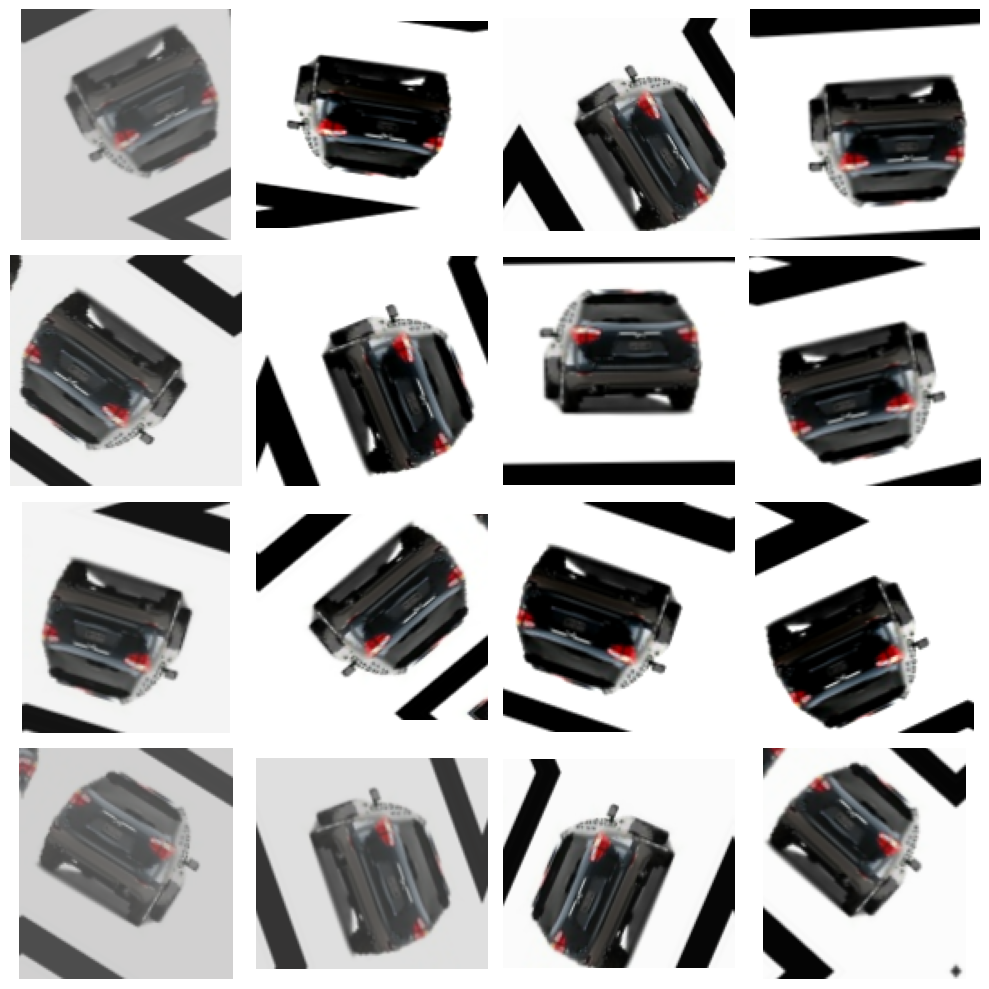

In [2]:
# all of the "factor" parameters indicate a percent-change
augment = keras.Sequential([
     preprocessing.RandomContrast(factor=0.5),
    preprocessing.RandomFlip(mode='horizontal'), # meaning, left-to-right
     preprocessing.RandomFlip(mode='vertical'), # meaning, top-to-bottom
     preprocessing.RandomWidth(factor=0.15), # horizontal stretch
     preprocessing.RandomRotation(factor=0.20),
     preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
])


ex = next(iter(ds_train.unbatch().map(lambda x, y: x).batch(1)))

plt.figure(figsize=(10,10))
for i in range(16):
    image = augment(ex, training=True)
    plt.subplot(4, 4, i+1)
    plt.imshow(tf.squeeze(image))
    plt.axis('off')
plt.show()

Do the transformations you chose seem reasonable for the *Car or Truck* dataset?

In this exercise, we'll look at a few datasets and think about what kind of augmentation might be appropriate. Your reasoning might be different that what we discuss in the solution. That's okay. The point of these problems is just to think about how a transformation might interact with a classification problem -- for better or worse.

The [EuroSAT](https://www.kaggle.com/ryanholbrook/eurosat) dataset consists of satellite images of the Earth classified by geographic feature. Below are a number of images from this dataset.

<figure>
<img src="refimages/cnn026.png" width=600, alt="Sixteen satellite images labeled: SeaLake, PermanentCrop, Industrial, Pasture, Residential, and Forest.">
</figure>

# 1) EuroSAT #

What kinds of transformations might be appropriate for this dataset?

Correct:

It seems to this author that flips and rotations would be worth trying first since there's no concept of orientation for pictures taken straight overhead. None of the transformations seem likely to confuse classes, however.


The [TensorFlow Flowers](https://www.kaggle.com/ryanholbrook/tensorflow-flowers) dataset consists of photographs of flowers of several species. Below is a sample.

<figure>
<img src="refimages/cnn027.png" width=600, alt="Sixteen images of flowers labeled: roses, tulips, dandelion, and sunflowers">
</figure>

# 2) TensorFlow Flowers #

What kinds of transformations might be appropriate for the TensorFlow Flowers dataset?

Correct:

It seems to this author that horizontal flips and moderate rotations would be worth trying first. Some augmentation libraries include transformations of hue (like red to blue). Since the color of a flower seems distinctive of its class, a change of hue might be less successful. On the other hand, there is suprising variety in cultivated flowers like roses, so, depending on the dataset, this might be an improvement after all!


Now you'll use data augmentation with a custom convnet similar to the one you built in Exercise 5. Since data augmentation effectively increases the size of the dataset, we can increase the capacity of the model in turn without as much risk of overfitting.

# 3) Add Preprocessing Layers #

Add these preprocessing layers to the given model.

```
preprocessing.RandomContrast(factor=0.10),
preprocessing.RandomFlip(mode='horizontal'),
preprocessing.RandomRotation(factor=0.10),
```


In [5]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.InputLayer(input_shape=[128, 128, 3]),
    
    # Data Augmentation
    # ____,
    preprocessing.RandomContrast(factor=0.10),
    preprocessing.RandomFlip(mode='horizontal'),
    preprocessing.RandomRotation(factor=0.10),
    # Block One
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Two
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Block Three
    layers.BatchNormalization(renorm=True),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(renorm=True),
    layers.Flatten(),
    layers.Dense(8, activation='relu'),
    layers.Dense(1, activation='sigmoid'),
])


Now we'll train the model. Run the next cell to compile it with a loss and accuracy metric and fit it to the training set.

In [6]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = model.fit(
    ds_train,
    validation_data=ds_valid,
    epochs=50,
)

# Plot learning curves
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

Epoch 1/50
 8/80 [==>...........................] - ETA: 14:54 - loss: 0.6906 - binary_accuracy: 0.5586

KeyboardInterrupt: 

# 4) Train Model #

Examine the training curves. What there any sign of overfitting? How does the performance of this model compare to other models you've trained in this course?

Solution: The learning curves in this model stayed close together for much longer than in previous models. This suggests that the augmentation helped prevent overfitting, allowing the model to continue improving.

And notice that this model achieved the highest accuracy of all the models in the course! This won't always be the case, but it shows that a well-designed custom convnet can sometimes perform as well or better than a much larger pretrained model. Depending on your application, having a smaller model (which requires fewer resources) could be a big advantage.


Conclusion¶

Data augmentation is a powerful and commonly-used tool to improve model training, not only for convolutional networks, but for many other kinds of neural network models as well. Whatever your problem, the principle remains the same: you can make up for an inadequacy in your data by adding in "fake" data to cover it over. Experimenting with augmentations is a great way to find out just how far your data can go!
